<a href="https://colab.research.google.com/github/toluwee/Machine_Learning_Projects/blob/master/Comparison_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

The compare different clustering algorithms and evaluate their performances in categorizing CO2 flooding projects.


# About The Dataset
The dataset is collated from extensive review and examination of successful pilot/field CO2 flooding projects that were published in Oil and Gas Journal biannual EOR surveys (from 1980 to 2014), SPE publications, DOE reports, and AAPG databases. 

It is a multivariate dataset with 170 rows of data and 12 features.Each row describes a CO2 Flooding project, and each column describes an attribute of the project. The twelve features are field , reservoir and fluid parameters which are selected and extracted because they are commonly available and used for EOR project data analysis. 

The information will be used to categorize global CO2 flooding projects into clusters of similar characteristics that can be referenced as benchmark or analogues for future projects.

The following is a description of the dataset.

**Attribute Information:**

| Position | Feature | Description |Feature Type |
|------:|:-----|---------|---------|
|[, 1]|	Area	|Area, acres|Numerical|
|[, 2]|	Prod_well|	No. of production wells|Numerical|
|[, 3]|	Inj_well|	No. of injection wells|Numerical|
|[, 4]|	Form|	Formation types (S: Sandst., LS: Limest., Dolo: Dolomite, Congl: Conglomerate, Tripol: Tripolite)|Categorical|
|[, 5]|	Por|	Porosity, %|Numerical|
|[, 6]|	Perm|	Permeability, md|Numerical|
|[, 7]|	Depth| Depth, ft|Numerical|
|[, 8]|	API|	Oil gravity, oAPI|Numerical|
|[, 9]|	Visc| Oil viscosity, cp|Numerical|
|[,10]|	Temp| Reservoir Temperature, oF|Numerical|
|[,11]|	Prev_prod	|Previous production type (GI: Gas injection, HC: Hydrocarbon, None: No prev., Prim: Primary, WF: Waterflood|Categorical|
|[,12]|	Sat_start	|Oil saturation at start of CO2 flooding, % |Numerical|


# Imports

In [1]:
!pip install --upgrade pip
!pip install numpy==1.16.0

     |████████████████████████████████| 1.5MB 9.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 17.3 MB 17 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

umap-learn 0.4.6 requires numpy>=1.17, but you'll have numpy 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import sklearn.cluster as cl
from sklearn.decomposition import PCA

import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
%config InlineBackend.figure_format='retina'
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score

import plotly.express as px


# Important! Runtime needs a restart at this point. Go to menubar "Runtime > Restart runtime..."
# Once restarted, you can resume
!pip install Cython
!pip install hdbscan

# You should now be able to import hdbscan
import hdbscan

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

import joblib


     |████████████████████████████████| 4.7 MB 7.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp36-cp36m-linux_x86_64.whl size=2301753 sha256=c099b3c2cf5a6867f098e587731b4269f5e811b33928df61f10fbc741e4a10e5
  Stored in directory: /root/.cache/pip/wheels/36/20/d1/521b2fbf637de5bc40668b6445944e7e44bfbe68fdaa65157d
Successfully built hdbscan


In [3]:
# Load in the data
filepath = 'https://datasciencefiles.s3.us-east-2.amazonaws.com/KMeans_CO2_data.csv'
df = pd.read_csv(filepath)


# Descriptive Statistics

In [4]:
from google.colab import data_table
data_table.DataTable(df)

,ID,Country,Operator,Field,Area,Prod_well,Inj_well,Form,Por,Perm,Depth,API,Visc,Temp,Prev_prod,Sat_start
0,1,US,Anadarko,Patrick Draw Monell,5800,79,40,S,20.00,30.0,5000,43.0,0.60,120,WF,39.00
1,2,US,Anadarko,Salt Creek Southern Unit,570,42,26,S,17.00,25.0,1750,39.0,0.60,105,Prim,32.00
2,3,US,Anadarko,Salt Creek Southern Unit,1325,48,32,S,18.00,30.0,2200,39.0,0.60,112,Prim,32.00
3,4,US,Anadarko,Salt Creek,3500,174,153,S,18.00,75.0,1900,37.0,0.60,105,WF,39.00
4,5,US,Anadarko,Salt Creek Ph 1-8,6000,321,279,S,18.00,75.0,1900,37.0,0.60,105,WF,39.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,172,Canada,Vikor,Jofrre Viking,480,6,2,S,13.00,500.0,5140,42.0,1.14,133,WF,38.00
162,173,Canada,Vikor,Jofrre Viking,480,4,1,S,13.00,500.0,5075,42.0,1.14,133,WF,36.00
163,174,Canada,Vikor,Jofrre Viking,1280,5,2,S,13.00,500.0,5000,42.0,1.14,133,WF,38.00
164,177,Hungary,Mol Rt KFV,Nagylengyel,2890,104,10,LS,1.06,1000.0,6700,18.0,22.00,237,Prim,48.03


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         166 non-null    int64  
 1   Country    166 non-null    object 
 2   Operator   166 non-null    object 
 3   Field      166 non-null    object 
 4   Area       166 non-null    int64  
 5   Prod_well  166 non-null    int64  
 6   Inj_well   166 non-null    int64  
 7   Form       166 non-null    object 
 8   Por        166 non-null    float64
 9   Perm       166 non-null    float64
 10  Depth      166 non-null    int64  
 11  API        166 non-null    float64
 12  Visc       166 non-null    float64
 13  Temp       166 non-null    int64  
 14  Prev_prod  166 non-null    object 
 15  Sat_start  166 non-null    float64
dtypes: float64(5), int64(6), object(5)
memory usage: 20.9+ KB


In [6]:
desc = df.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc.iloc[1:] = desc.iloc[1:].applymap('{:.0f}'.format)
desc

,ID,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start
count,166,166,166,166,166,166,166,166,166,166,166
mean,90,3594,72,50,15,166,6097,37,2,136,48
std,50,6096,133,102,7,560,2258,5,3,46,13
min,1,5,1,1,1,2,1150,18,0,80,17
25%,48,469,8,4,10,5,4900,34,1,104,39
50%,92,1325,29,17,13,30,5500,38,1,112,48
75%,133,4319,76,44,18,69,6950,41,2,152,52
max,179,49900,1026,816,37,4500,11950,48,22,260,89


# Data Wrangling

## Data type conversion 

In [7]:
"""
The 'Object' data types Form and Prev_prod are first converted to 
#category and then numeric codes for these categories are generated 
"""
df.Form = df.Form.astype('category')
df.Prev_prod = df.Prev_prod.astype('category')
df["Form_cat"] = df.Form.cat.codes
df["Prev_prod_cat"] = df.Prev_prod.astype('category').cat.codes

In [8]:
print(df.Form.cat.categories)
print(df.Form_cat.value_counts(sort= False))

Index(['Congl', 'Dolo', 'LS', 'S', 'Tripol'], dtype='object')
0     1
1    60
2    27
3    72
4     6
Name: Form_cat, dtype: int64


In [9]:
print(df.Prev_prod.cat.categories)
print(df.Prev_prod_cat.value_counts(sort= False))

Index(['GI', 'HC', 'None', 'Prim', 'WF'], dtype='object')
0      4
1      1
2      3
3     31
4    127
Name: Prev_prod_cat, dtype: int64


## Drop redundant columns

Save the ID column for later combination to results.

Drop the ID, Form and Prev_prod columns in dataset

In [10]:
df_out = df.drop (columns=['ID','Form','Prev_prod','Country', 'Operator', 'Field'])
df_out.head(5)

,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start,Form_cat,Prev_prod_cat
0,5800,79,40,20.0,30.0,5000,43.0,0.6,120,39.0,3,4
1,570,42,26,17.0,25.0,1750,39.0,0.6,105,32.0,3,3
2,1325,48,32,18.0,30.0,2200,39.0,0.6,112,32.0,3,3
3,3500,174,153,18.0,75.0,1900,37.0,0.6,105,39.0,3,4
4,6000,321,279,18.0,75.0,1900,37.0,0.6,105,39.0,3,4


In [11]:
desc = df_out.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc.iloc[1:] = desc.iloc[1:].applymap('{:.0f}'.format)
desc

,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start,Form_cat,Prev_prod_cat
count,166,166,166,166,166,166,166,166,166,166,166,166
mean,3594,72,50,15,166,6097,37,2,136,48,2,4
std,6096,133,102,7,560,2258,5,3,46,13,1,1
min,5,1,1,1,2,1150,18,0,80,17,0,0
25%,469,8,4,10,5,4900,34,1,104,39,1,4
50%,1325,29,17,13,30,5500,38,1,112,48,2,4
75%,4319,76,44,18,69,6950,41,2,152,52,3,4
max,49900,1026,816,37,4500,11950,48,22,260,89,4,4


In [12]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Area           166 non-null    int64  
 1   Prod_well      166 non-null    int64  
 2   Inj_well       166 non-null    int64  
 3   Por            166 non-null    float64
 4   Perm           166 non-null    float64
 5   Depth          166 non-null    int64  
 6   API            166 non-null    float64
 7   Visc           166 non-null    float64
 8   Temp           166 non-null    int64  
 9   Sat_start      166 non-null    float64
 10  Form_cat       166 non-null    int8   
 11  Prev_prod_cat  166 non-null    int8   
dtypes: float64(5), int64(5), int8(2)
memory usage: 13.4 KB


## Correlation

An heatmap is plotted to get a feel for how the correlations between the different features compare to one another. 

Text(0.5, 1.05, 'Correlation of Features')

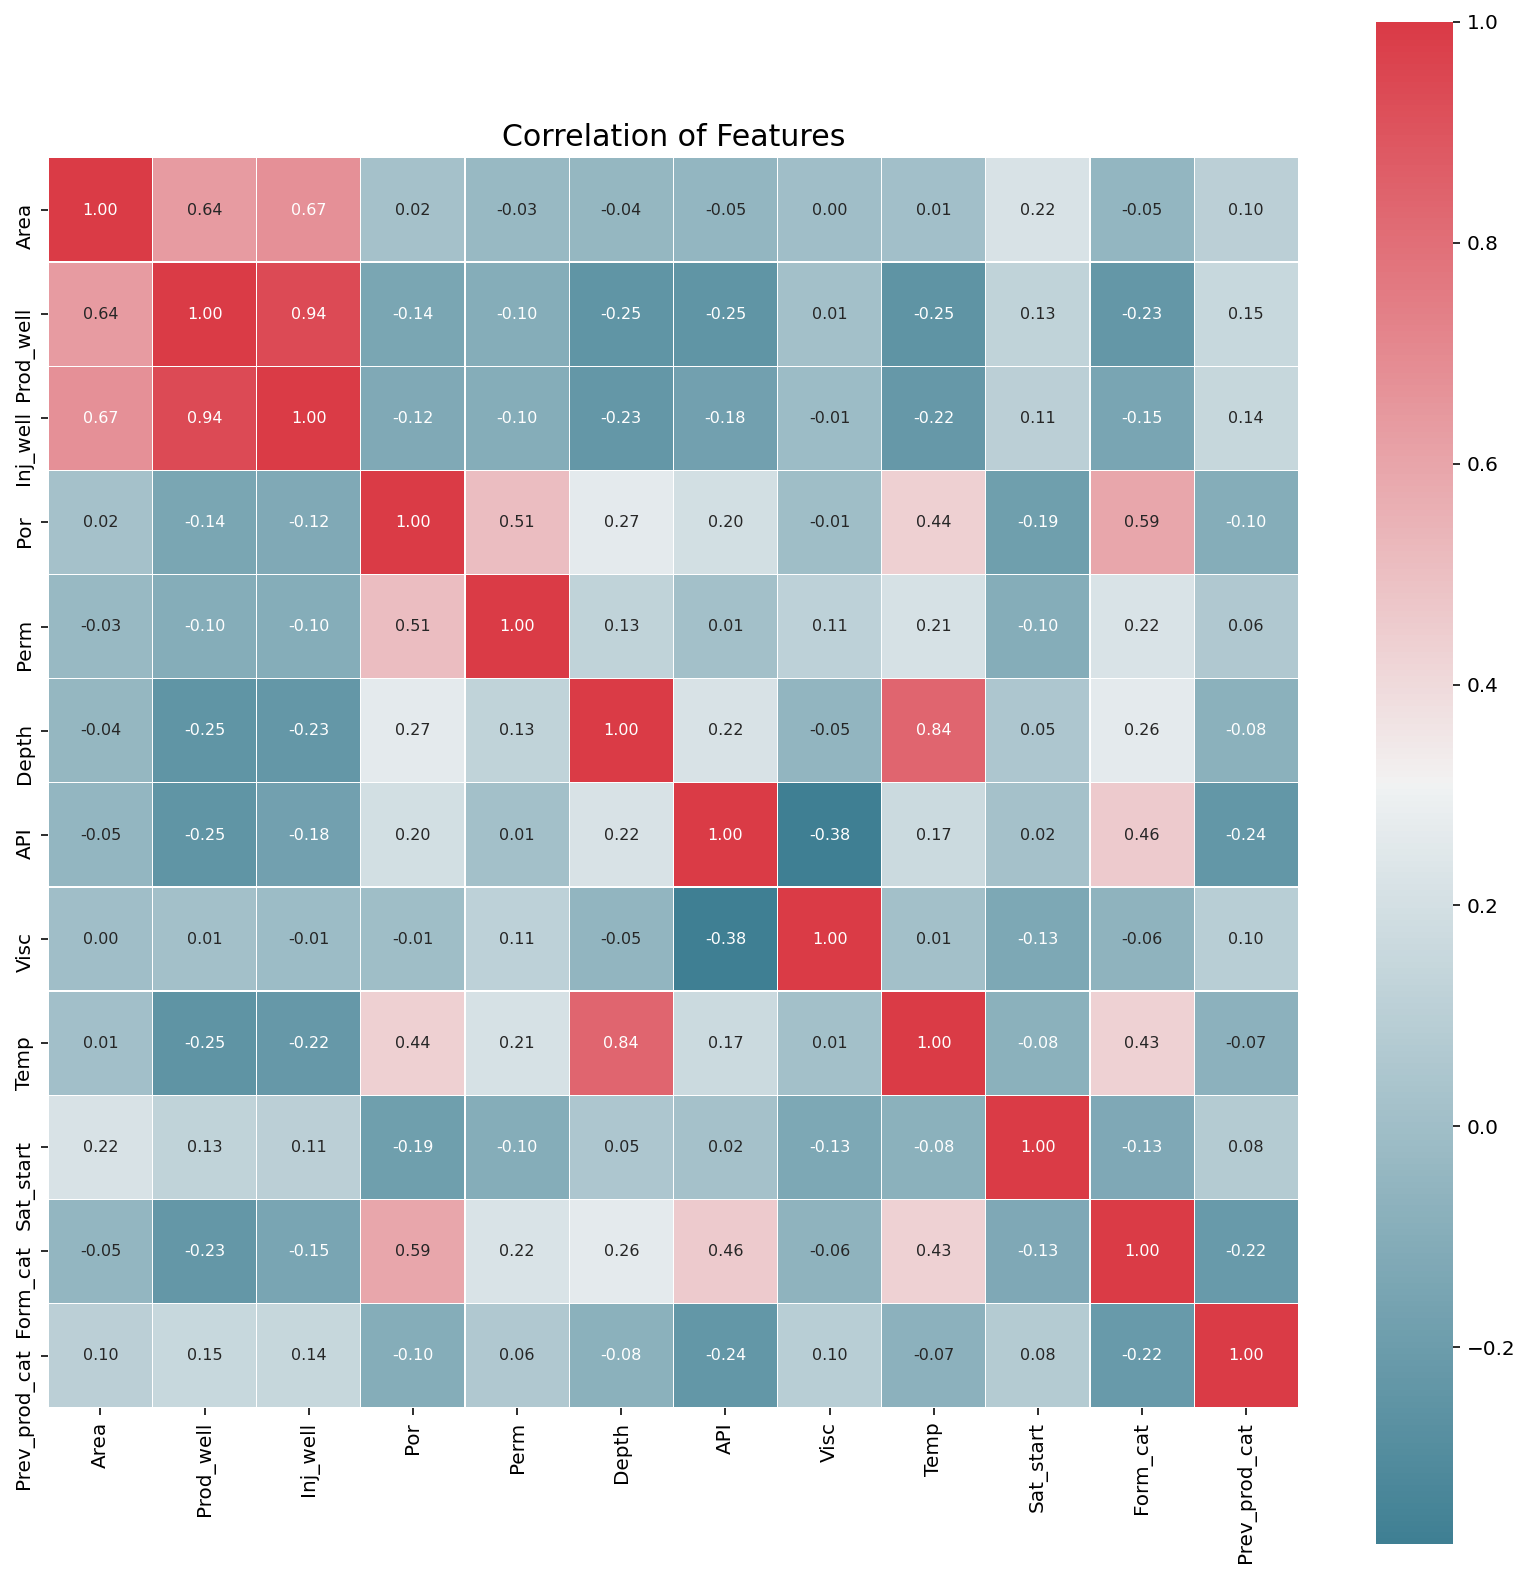

In [13]:
corr = df_out.corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 8},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of Features', y=1.05, size=15)

Figure  depicts the correlation between different columns. Yellow and shades of green show positive correlations while Purple and shades of blue show negatively correlated features. 

Prod_well and Inj_well are seen to be highly positively correlated to Area since the bigger the field, the higher the number of wells drillable. Also, Por is positively correlated to Perm while API has a high negative correlation to Visc. 
All these correlations are indicators that linearly correlated features can be found to perform PCA projections on.

Next pairplot of the features is made to identify distibutions and outliers

In [14]:
# sns.pairplot(df_out)

'Visc', 'Perm', 'Area',	'Prod_well',	'Inj_well' are all identified to have several 'special cases'. These cases significantly skew the distribution for these features. There is a need to handle these outliers before standardization.

## Handling outliers

Rather than delete the outlier rows in these features, the values of these rows are capped to an amount grreater than the 3rd quantile vale for that feature. 
This is done so that these values can have a chance to contribute their importance to the features without making the distribution skewed.

In [15]:
Outlier_col = ['Visc', 'Perm', 'Area',	'Prod_well',	'Inj_well'] # columns identified in pairplot as having large outliers

for col in Outlier_col:
  val = df[col].quantile(0.75) * 1.5  # upper limit calculated by increasing 3rd quantile value by 50%
  df_out[col] = np.where(df_out[col] > val , val, df_out[col])   # replacing the outliers



The distribution shows that the influence of outliers have been reduced in the columns.

In [16]:
desc = df_out.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc.iloc[1:] = desc.iloc[1:].applymap('{:.0f}'.format)
desc


,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start,Form_cat,Prev_prod_cat
count,166,166,166,166,166,166,166,166,166,166,166,166
mean,2394,43,26,15,41,6097,37,1,136,48,2,4
std,2346,41,25,7,38,2258,5,1,46,13,1,1
min,5,1,1,1,2,1150,18,0,80,17,0,0
25%,469,8,4,10,5,4900,34,1,104,39,1,4
50%,1325,29,17,13,30,5500,38,1,112,48,2,4
75%,4319,76,44,18,69,6950,41,2,152,52,3,4
max,6478,114,67,37,104,11950,48,3,260,89,4,4


In [18]:
df_out.head(5)

,Area,Prod_well,Inj_well,Por,Perm,Depth,API,Visc,Temp,Sat_start,Form_cat,Prev_prod_cat
0,5800.0,79.000,40.00,20.0,30.0,5000,43.0,0.6,120,39.0,3,4
1,570.0,42.000,26.00,17.0,25.0,1750,39.0,0.6,105,32.0,3,3
2,1325.0,48.000,32.00,18.0,30.0,2200,39.0,0.6,112,32.0,3,3
3,3500.0,113.625,66.75,18.0,75.0,1900,37.0,0.6,105,39.0,3,4
4,6000.0,113.625,66.75,18.0,75.0,1900,37.0,0.6,105,39.0,3,4


## Dataset visualization

The dataset will be visualized to see if any clusters with similarities can be observed just by eyeballing method

In [19]:
fig = px.scatter(data_frame=df_out,
                    x="Por",
                    y="Perm",
                    )

fig.show()


In [20]:

fig = px.scatter_3d(data_frame=df_out,
                    x= df_out.Por,
                    y= df_out.Perm,
                    z =df_out.Depth,
                               
                    )

fig.show()

Perhaps one small cluster can be seen with several blobs evident around

## Standardization

The decision to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, since it was measured on different scales. The data will be transformed onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.
The data is standardized using sklearn's StandardScaler.

In [21]:
# Standardize the data to have a mean of ~0 and a variance of 1
df_std = StandardScaler().fit_transform(df_out)



# Algorithm Comparison

### With Known Ground Truth

In [22]:
def cluster_eval(data,labels_true, algorithm, args, kwds):
    model = algorithm(*args, **kwds).fit(data)
    labels_pred = model.labels_
    print('Fowlkes Mallows score:', metrics.fowlkes_mallows_score(labels_true, labels_pred) )
    print('Adjusted Rand index:', metrics.adjusted_rand_score(labels_true, labels_pred)) 
    print('Homogeneity score: ', metrics.homogeneity_score(labels_true, labels_pred))
    print('Completeness score: ', metrics.completeness_score(labels_true, labels_pred))
    print('V-measure score: ', metrics.v_measure_score(labels_true, labels_pred))
    

Selecting a column with known classes as target column. Only algorithms where no of clusters can be declared are used here to ensure comparison of apples with apples.

In [23]:
# create target column 
labels_true = df_out.Form_cat

In [24]:
cluster_eval(df_std, labels_true, cl.KMeans, (), {'n_clusters':5})

Fowlkes Mallows score: 0.4775693277664789
Adjusted Rand index: 0.27941763975170986
Homogeneity score:  0.44769787202774136
Completeness score:  0.3284907523435271
V-measure score:  0.3789403920319362


In [25]:
cluster_eval(df_std, labels_true,cl.AgglomerativeClustering, (), {'n_clusters':5, 'linkage':'ward'})

Fowlkes Mallows score: 0.42674279037481366
Adjusted Rand index: 0.21116704636307473
Homogeneity score:  0.3605449138443106
Completeness score:  0.2672447271803708
V-measure score:  0.3069618255545728


## Without Known Ground Truth

As is usually the case, when target classes are not known, the following metrics can be used to evaluate cluster algorithm performances.

In [26]:
def plot_clusters(data, algorithm, args, kwds):
    model = algorithm(*args, **kwds).fit_predict(data)
          
    clusters = np.unique(model)
    # create scatter plot for samples from each cluster
    for cluster in clusters:
	    # get row indexes for samples with this cluster
	    row_ix = np.where(model == cluster)
	    # create scatter of these samples
	    pyplot.scatter(data[row_ix, 0], data[row_ix, 1])
      # show the plot
    pyplot.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=16)
    pyplot.show()

    print('Silhouette score is', metrics.silhouette_score(data, model, metric='euclidean'))
    print('Calinski Harabasz score is', metrics.calinski_harabasz_score(data, model))
    print('Davies Bouldin score is', davies_bouldin_score(data, model))

### KMeans

Centroid-based clustering

### Parameter determination

Using Silhouette Score method to select number of cluster

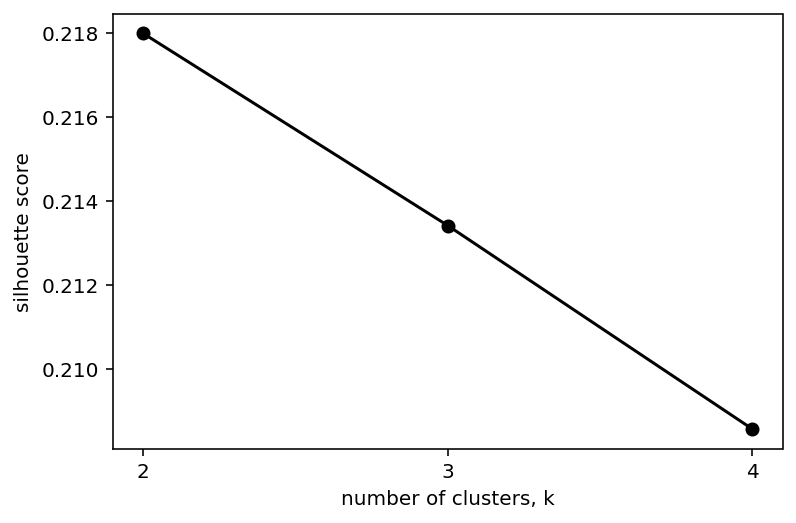

In [27]:
ks = range(2, 5)
silhouette = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = cl.KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(df_std)
    
    # Append the inertia to the list of inertias
    silhouette.append(silhouette_score(df_std, model.labels_))
    
plt.plot(ks, silhouette, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette score')
plt.xticks(ks)
plt.show()

Cluster number of 2 is then chosen for the KMeans implementation

### Implementation

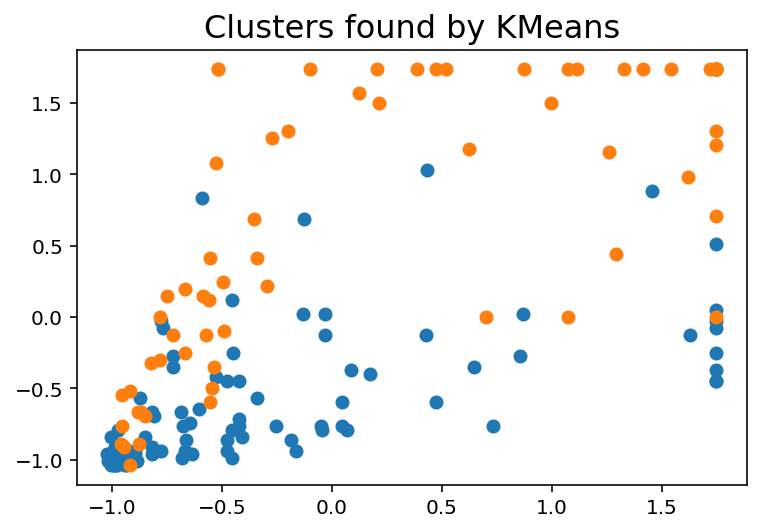

Silhouette score is 0.21798123676600925
Calinski Harabasz score is 50.35277151668891
Davies Bouldin score is 1.7050064367241304


In [28]:
plot_clusters(df_std, cl.KMeans, (), {'n_clusters':2})

## Spectral Clustering

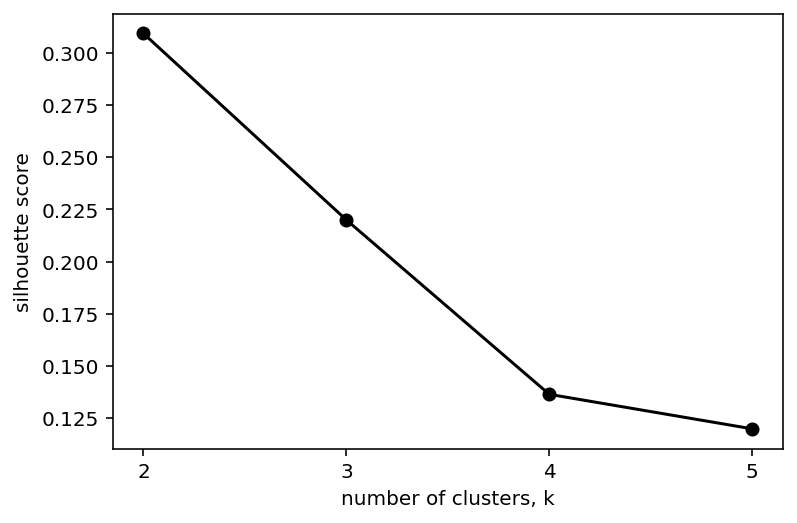

In [29]:
ks = range(2, 6)
silhouette = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = cl.SpectralClustering(n_clusters=k)
    
    # Fit model to samples
    model.fit(df_std)
    
    # Append the inertia to the list of inertias
    silhouette.append(silhouette_score(df_std, model.labels_))
    
plt.plot(ks, silhouette, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette score')
plt.xticks(ks)
plt.show()

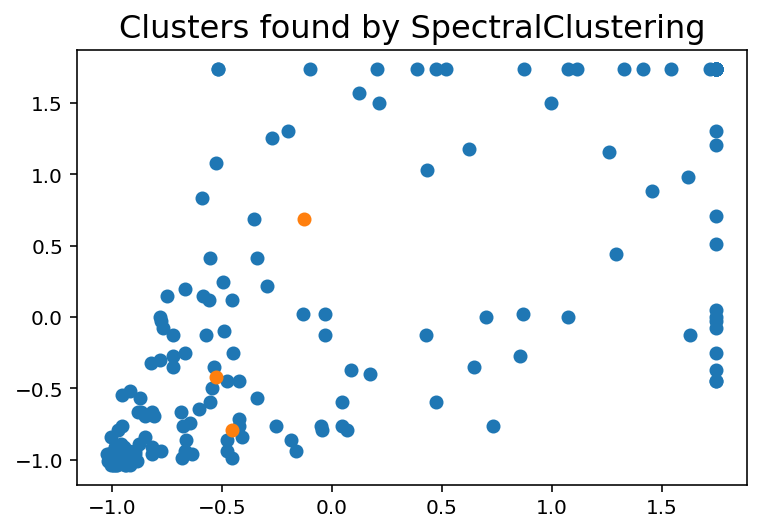

Silhouette score is 0.3092648747844164
Calinski Harabasz score is 8.422261375214184
Davies Bouldin score is 0.7523406473061841


In [30]:
plot_clusters(df_std, cl.SpectralClustering, (), {'n_clusters':2})

## Hierarchical clustering

Connectivity-based clustering (hierarchical clustering)

### Parameter determination

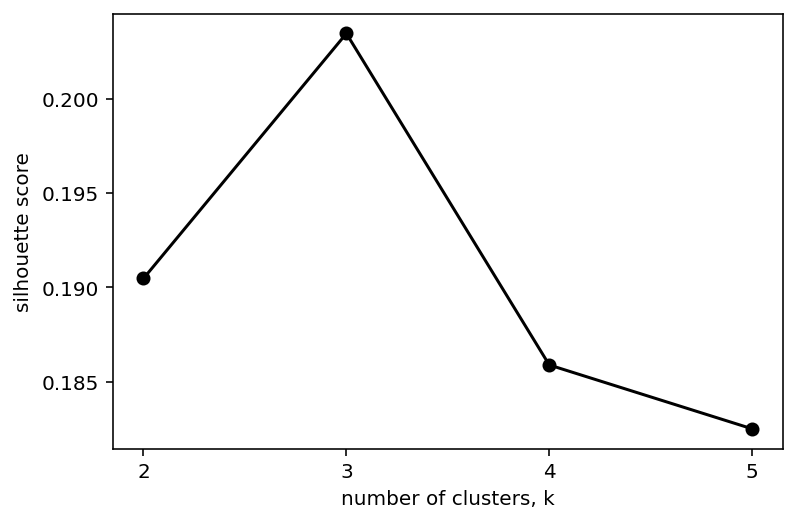

In [31]:
ks = range(2, 6)
silhouette = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = cl.AgglomerativeClustering(n_clusters=k)
    
    # Fit model to samples
    model.fit(df_std)
    
    # Append the inertia to the list of inertias
    silhouette.append(silhouette_score(df_std, model.labels_))
    
plt.plot(ks, silhouette, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette score')
plt.xticks(ks)
plt.show()

### Implementation

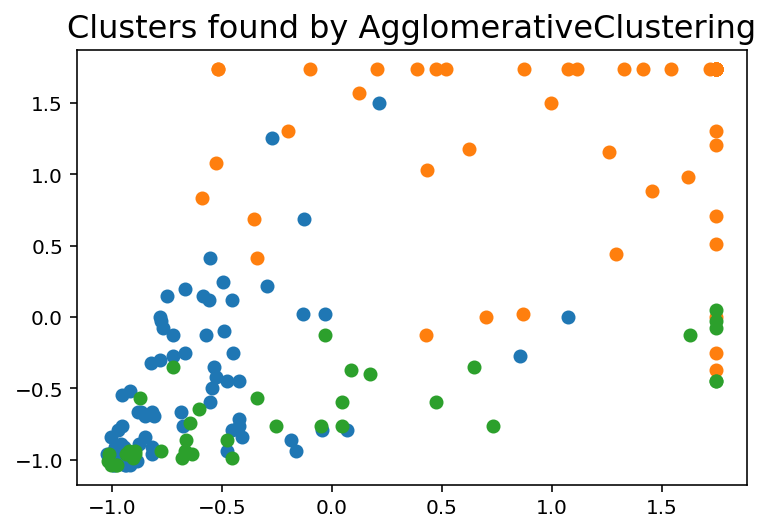

Silhouette score is 0.20347318388710003
Calinski Harabasz score is 41.78700119893566
Davies Bouldin score is 1.663493520358129


In [32]:
plot_clusters(df_std, cl.AgglomerativeClustering, (), {'n_clusters':3})

In [33]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

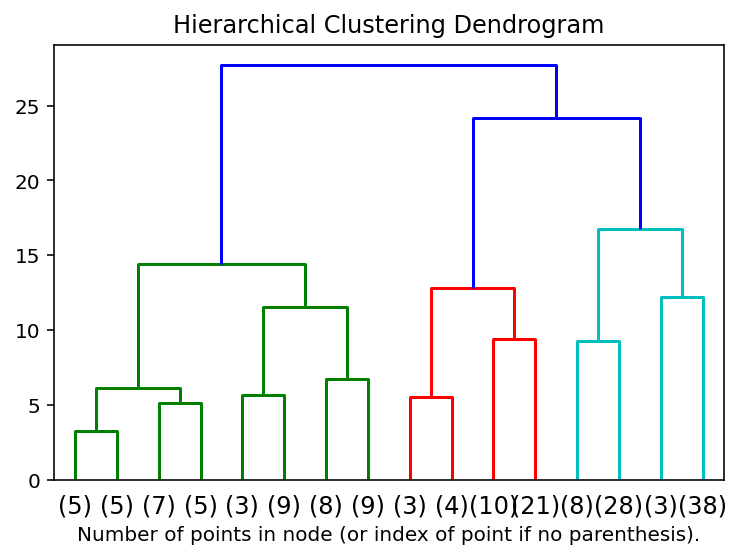

In [34]:
model_agg = cl.AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model_agg = model_agg.fit(df_std)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model_agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## DBSCAN
Density-based clustering

As mentioned previously, we must provide a value for epsilon which defines the maximum distance between two points. The following paper, describes an approach for automatically determining the optimal value for Eps.
https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

In layman’s terms, we find a suitable value for epsilon by calculating the distance to the nearest n points for each point, sorting and plotting the results. Then we look to see where the change is most pronounced (think of the angle between your arm and forearm) and select that as epsilon.

We can calculate the distance from each point to its closest neighbour using the NearestNeighbors. The point itself is included in n_neighbors. The kneighbors method returns two arrays, one which contains the distance to the closest n_neighbors points and the other which contains the index for each of those points.

### Parameter determination

In [35]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors()
nbrs = neigh.fit(df_std)
distances, indices = nbrs.kneighbors(df_std)

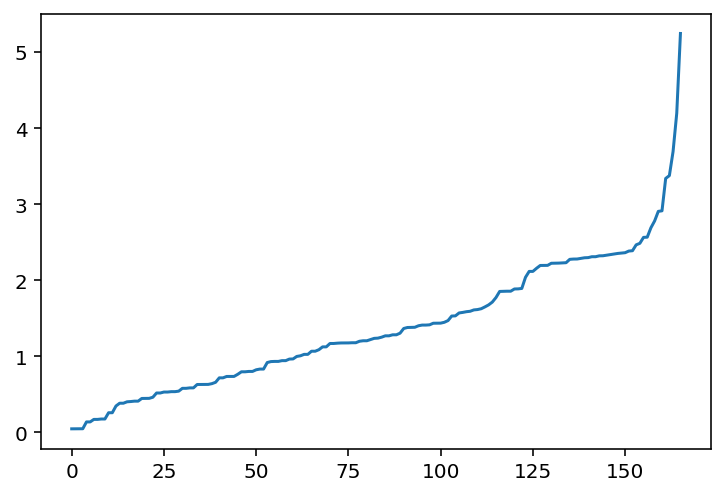

In [36]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

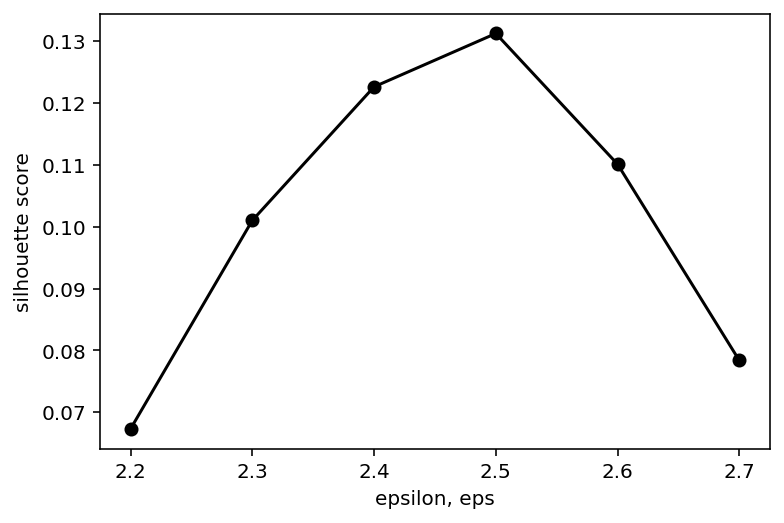

In [37]:
ks = [2.2,2.3,2.4,2.5,2.6,2.7]
silhouette = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = cl.DBSCAN(eps=k, min_samples=12)
    
    # Fit model to samples
    model.fit(df_std)
    
    # Append the inertia to the list of inertias
    silhouette.append(silhouette_score(df_std, model.labels_))
    
plt.plot(ks, silhouette, '-o', color='black')
plt.xlabel('epsilon, eps')
plt.ylabel('silhouette score')
plt.xticks(ks)
plt.show()

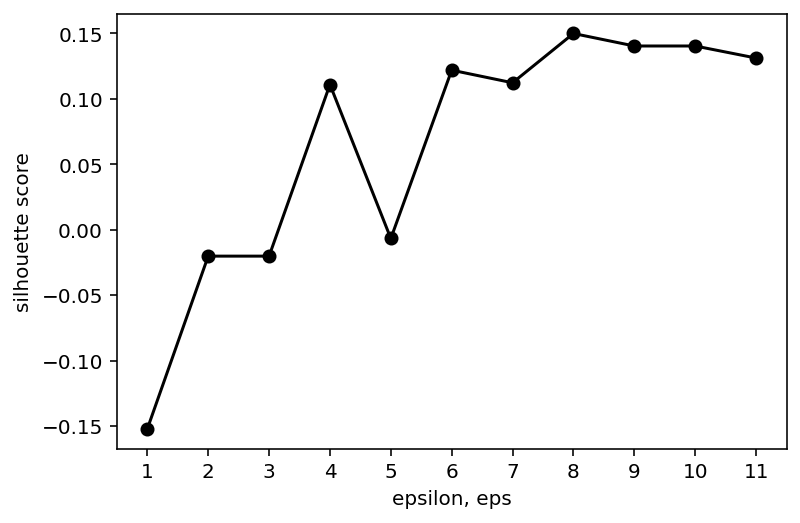

In [38]:
ks = ks = range(1, 12)
silhouette = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = cl.DBSCAN(eps=2.5, min_samples=k)
    
    # Fit model to samples
    model.fit(df_std)
    
    # Append the inertia to the list of inertias
    silhouette.append(silhouette_score(df_std, model.labels_))
    
plt.plot(ks, silhouette, '-o', color='black')
plt.xlabel('epsilon, eps')
plt.ylabel('silhouette score')
plt.xticks(ks)
plt.show()

### Implementation

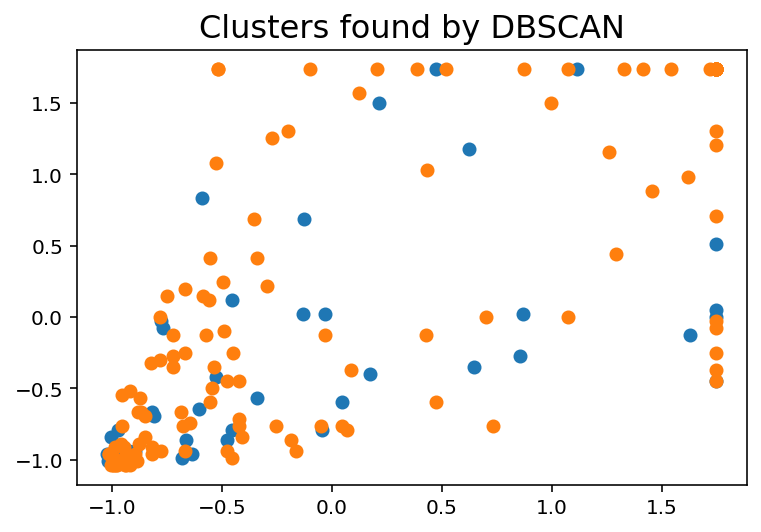

Silhouette score is 0.11232246434664019
Calinski Harabasz score is 8.23155436022708
Davies Bouldin score is 3.8970817998165437


In [39]:
plot_clusters(df_std, cl.DBSCAN, (), {'eps':2.5, 'min_samples':7})

## HDBSCAN

Valid values for min_cluster_size are 2 to D, where D is the number of features of the data set, in this case 12.

### Parameter determination

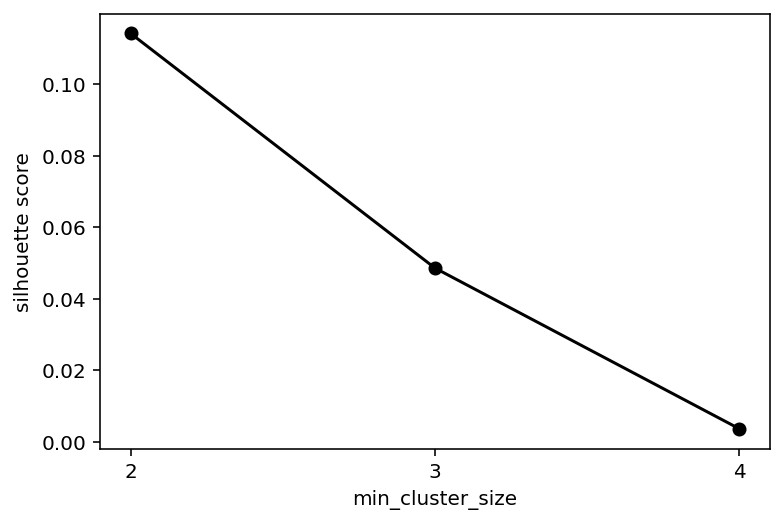

In [45]:
ks = range(2,5)
silhouette = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = hdbscan.HDBSCAN(min_cluster_size=k)
    
    # Fit model to samples
    model.fit(df_std)
    
    # Append the inertia to the list of inertias
    silhouette.append(silhouette_score(df_std, model.labels_))
    
plt.plot(ks, silhouette, '-o', color='black')
plt.xlabel('min_cluster_size')
plt.ylabel('silhouette score')
plt.xticks(ks)
plt.show()

### Implementation

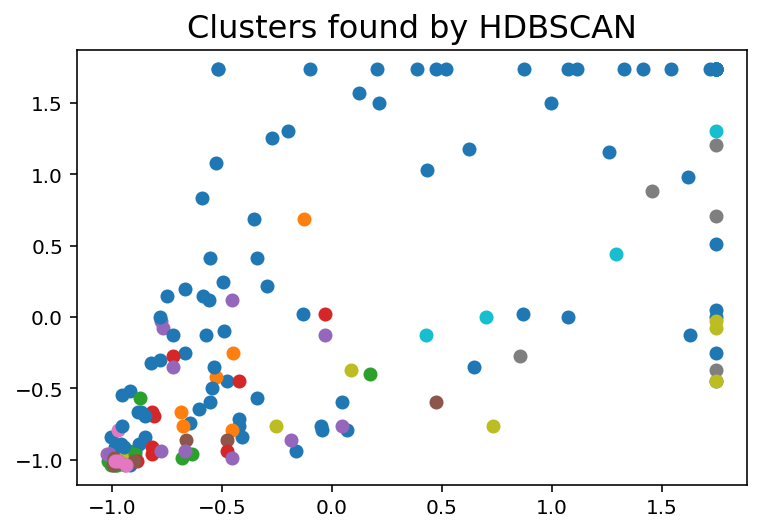

Silhouette score is 0.11419504806788285
Calinski Harabasz score is 10.324761432416844
Davies Bouldin score is 1.6135946715515583


In [41]:
plot_clusters(df_std, hdbscan.HDBSCAN, (), {'min_cluster_size':2})

K-Means outperforms all other clustering algorithms on most metrics. 

However, centroid-based algorithms will perform well using this metrics due to the parameters measured in the metrics. 
See for more details.

We proceed to implement PCA on Kmeans to get better definition of these clusters by reducing the dimensions.

## LOOCV

In [42]:
def loocv(Features,target,algorithm,args, kwds):
  # create loocv procedure
  cv = LeaveOneOut()
  # create model
  model = algorithm(*args, **kwds)
  # evaluate model
  scores = cross_val_score(model, Features,target, scoring='accuracy', cv=cv, n_jobs=-1)
  # report performance
  print('Accuracy of {0:s}: {1:.3f} ({2:.3f})'.format(algorithm.__name__, np.mean(scores), np.std(scores)))

In [43]:
X_loocv = df_out.drop(columns='Form_cat')
y_loocv = df_out.Form_cat

In [44]:
loocv(X_loocv ,y_loocv ,cl.KMeans,(), {'n_clusters':5})

Accuracy of KMeans: 0.229 (0.420)


Agglomerative can not be used here because the algorithm is not predictive.